# Cluster headache simulations: Full model

In [51]:
import numpy as np
from scipy.stats import lognorm, gmean, rv_discrete, norm, stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Groups

We'll use stratified sampling, meaning that we will simulate subgroups of CH sufferers with common traits separately. We'll start with four groups defined by episodic vs chronic and treated vs untreated.

In [52]:
# Define the overall population
annual_prevalence = 53/100000 # 53 per 100,000 (95% CI: 26, 95) of adults
world_population = 8_200_000_000
adult_fraction = 0.72
total_sufferers = world_population * adult_fraction * annual_prevalence # Estimated global CH sufferers

# Define the proportions for each group
prop_episodic = 0.80
prop_chronic = 1 - prop_episodic
prop_treated = 0.48
prop_untreated = 1 - prop_treated

# Define the groups
ch_groups = {
    "episodic_treated": {
        "proportion": prop_episodic * prop_treated,
        "bouts_per_year": 0,
        "bout_duration_weeks": 0,
        "attack_duration_minutes": 0,
        "pain_intensity": 0,
    },
    "episodic_untreated": {
        "proportion": prop_episodic * prop_untreated,
        "bouts_per_year": 0,
        "bout_duration_weeks": 0,
        "attack_duration_minutes": 0,
        "pain_intensity": 0,
    },
    "chronic_treated": {
        "proportion": prop_chronic * prop_treated,
        "attacks_per_day": 0,
        "attack_duration_minutes": 0,
        "pain_intensity": 0,
    },
    "chronic_untreated": {
        "proportion": prop_chronic * prop_untreated,
        "attacks_per_day": 0,
        "attack_duration_minutes": 0,
        "pain_intensity": 0,
    }
}

# Calculate the number of sufferers in each group
for group in ch_groups:
    ch_groups[group]["sufferers"] = int(total_sufferers * ch_groups[group]["proportion"])

# Print out the group sizes
for group, data in ch_groups.items():
    print(f"{group}: {data['sufferers']:,} sufferers")

episodic_treated: 1,201,582 sufferers
episodic_untreated: 1,301,713 sufferers
chronic_treated: 300,395 sufferers
chronic_untreated: 325,428 sufferers


## Modeling annual bout frequency for episodic CH sufferers

General idea: For ease of understanding, assume CH sufferers have an integer number of bouts per year. Combine data from papers reporting bout frequency. Use a simple discrete distribution.

In [53]:
data = {
    # Discretized approximation for a distribution with mean 1.2, SD 1.1
    'Gaul': {'n': 209, 'dist': {0: 0.2, 1: 0.4, 2: .3, 3:.1}},  
    
    # Split "<1/year" between 0 and 1, ">1/year" between 2 and 3
    'Li': {'n': 327, 'dist': {0: 0.416 * 0.5, 1: 0.416 * 0.5 + 0.370, 2: 0.214 * 0.5, 3: 0.214 * 0.5}},
    
    # Split "1/1.5-2 years" between 0 and 1
    'Friedman': {'n': 50, 'dist': {0: 0.46 * 0.5, 1: 0.46 * 0.5 + 0.54}},
    
    # Split "<1/year" between 0 and 1
    'Ekbom': {'n': 105, 'dist': {0: 0.14 * 0.5, 1: 0.14 * 0.5 + 0.40, 2: 0.31, 3: 0.15}},
    
    # Split "1-2/year" evenly between 1 and 2
    'Manzoni': {'n': 161, 'dist': {0: 0.27, 1: 0.73 * 0.5, 2: 0.73 * 0.5}},
    
    # Converted from remission periods to bouts/year, chronic cases removed
    'Sutherland': {'n': 49, 'dist': {
        0: 0.512 * 0.5 + 0.174,  # Half of 1-5 years + >5 years
        1: 0.140 + 0.512 * 0.5,  # 6-12 months + half of 1-5 years
        2: 0.174                 # 3-6 months
    }},
    
    # Estimated from remission periods, splitting some categories
    'Kudrow': {'n': 428, 'dist': {0: 0.19, 1: 0.67 * 0.5 + 0.14 * 0.5, 2: 0.67 * 0.5, 3: 0.14 * 0.5}}
}

# Combine distributions
combined_dist = {}
total_n = sum(study['n'] for study in data.values())

for study in data.values():
    weight = study['n'] / total_n
    for bouts, prob in study['dist'].items():
        combined_dist[bouts] = combined_dist.get(bouts, 0) + prob * weight

# Normalize the combined distribution
total_prob = sum(combined_dist.values())
combined_dist = {k: v/total_prob for k, v in combined_dist.items()}

# Create custom discrete distribution
bouts_per_year = rv_discrete(values=(list(combined_dist.keys()), list(combined_dist.values())))

# Print statistics from distribution
mean_dist = bouts_per_year.mean()
median_dist = bouts_per_year.median()
print("Distribution statistics:")
print(f"Mean: {mean_dist:.4f}")
print(f"Median: {median_dist:.4f}")
print("Distribution:")
for value, prob in sorted(combined_dist.items()):
    print(f"Percentage {value} bouts/year: {prob*100:.1f}%")
    
# Print statistics from samples
samples = bouts_per_year.rvs(size=100000)
mean_samples = np.mean(samples)
median_samples = np.median(samples)
print("\nSample statistics:")
print(f"Mean: {mean_samples:.4f}")
print(f"Median: {median_samples:.4f}")
for i in range(4):
    print(f"Percentage {i} bouts/year: {(samples == i).mean()*100:.1f}%")

Distribution statistics:
Mean: 1.2028
Median: 1.0000
Distribution:
Percentage 0 bouts/year: 20.7%
Percentage 1 bouts/year: 46.0%
Percentage 2 bouts/year: 25.7%
Percentage 3 bouts/year: 7.6%

Sample statistics:
Mean: 1.2035
Median: 1.0000
Percentage 0 bouts/year: 20.7%
Percentage 1 bouts/year: 46.0%
Percentage 2 bouts/year: 25.6%
Percentage 3 bouts/year: 7.7%


## Modeling bout duration for episodic CH sufferers

General idea: Fit a lognormal distribution based on the datapoints I gathered from 8 papers.

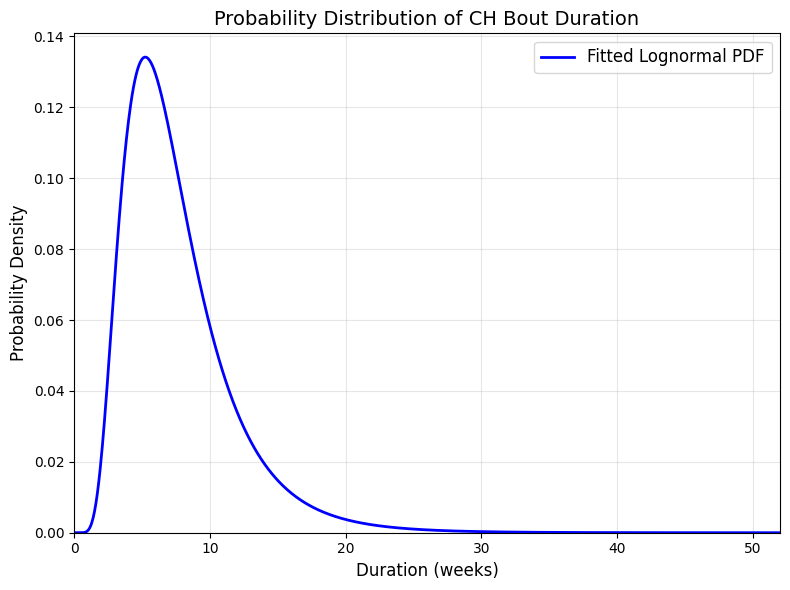

10th percentile: 3.55 weeks
25th percentile: 4.81 weeks
50th percentile: 6.74 weeks
75th percentile: 9.44 weeks
90th percentile: 12.79 weeks
99th percentile: 21.56 weeks


In [54]:
data = []
sample_sizes = []

# Gaul et al. (2012)
data.append(8.5)
sample_sizes.append(209)

# Li et al. (2022)
total_li = 327
data.extend([1, gmean([2, 4]), gmean([4, 8]), 8])
sample_sizes.extend([int(0.104 * total_li), int(0.235 * total_li), int(0.502 * total_li), int(0.131 * total_li)])

# Friedman & Mikropoulos (1958)
data.append(gmean([6, 8]))
sample_sizes.append(50)

# Ekbom (1970)
data.append(gmean([4, 12]))
sample_sizes.append(105)

# Lance & Anthony (1971)
data.append(gmean([2, 12]))
sample_sizes.append(60)

# Sutherland & Eadie (1972)
total_sutherland = 58
data.extend([gmean([0, 4]), gmean([5, 13]), gmean([14, 26]), gmean([27, 52])])
sample_sizes.extend([int(0.23 * total_sutherland), int(0.45 * total_sutherland), 
                     int(0.19 * total_sutherland), int(0.04 * total_sutherland)])

# Rozen & Fishman (2012)
data.append(10.3)
sample_sizes.append(101)

# Manzoni et al. (1983)
data.append(gmean([4, 8]))
sample_sizes.append(161)

# Convert to numpy arrays
data = np.array(data)
sample_sizes = np.array(sample_sizes)

# Use sample sizes as weights
weights = sample_sizes / np.sum(sample_sizes)

# Fitting the lognormal distribution
def neg_log_likelihood(params):
    mu, sigma = params
    return -np.sum(weights * lognorm.logpdf(data, s=sigma, scale=np.exp(mu)))

initial_params = [np.log(np.average(data, weights=weights)), 0.5]
result = minimize(neg_log_likelihood, initial_params, method='Nelder-Mead')
optimal_mu, optimal_sigma = result.x

# Plotting
plt.figure(figsize=(8, 6))

x = np.linspace(0, 52, 1000)
plt.plot(x, lognorm.pdf(x, s=optimal_sigma, scale=np.exp(optimal_mu)), 'b-', lw=2, 
         label='Fitted Lognormal PDF')

plt.title('Probability Distribution of CH Bout Duration', fontsize=14)
plt.xlabel('Duration (weeks)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.xlim(0, 52)
plt.ylim(bottom=0)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print percentiles
percentiles = [10, 25, 50, 75, 90, 99]
values = lognorm.ppf(np.array(percentiles) / 100, s=optimal_sigma, scale=np.exp(optimal_mu))
for p, v in zip(percentiles, values):
    print(f"{p}th percentile: {v:.2f} weeks")

## Modeling attacks per day for both episodic and chronic CH sufferers

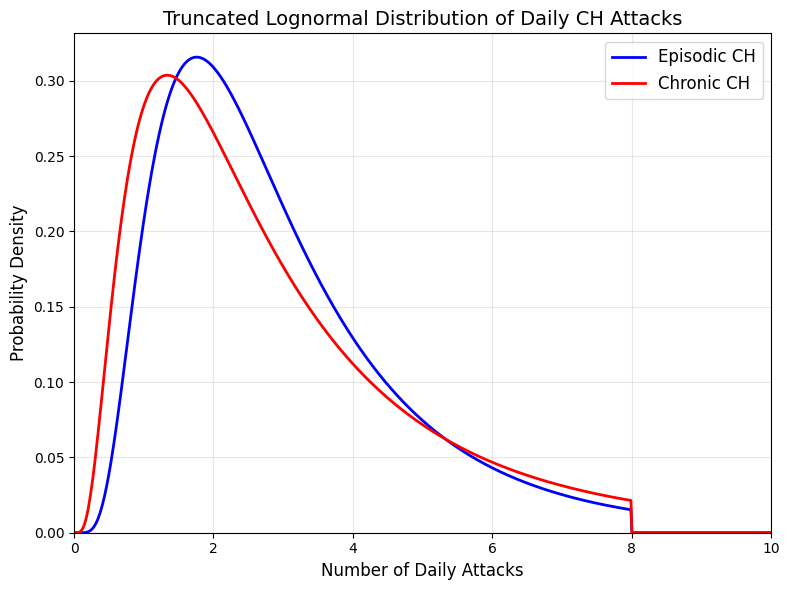


Episodic CH:
Truncated Mean: 3.10
Median: min(8, 2.57)
Probability of >5 and ≤8 attacks/day: 0.1103
Probability of 8 attacks/day: 0.0322
Parameters - mu: 0.9426, sigma: 0.6146

Chronic CH:
Truncated Mean: 3.30
Median: min(8, 2.44)
Probability of >5 and ≤8 attacks/day: 0.1225
Probability of 8 attacks/day: 0.0631
Parameters - mu: 0.8927, sigma: 0.7761

Episodic CH Percentiles:
10th percentile: 1.17 attacks/day
25th percentile: 1.70 attacks/day
50th percentile: 2.57 attacks/day
75th percentile: 3.88 attacks/day
90th percentile: 5.64 attacks/day
99th percentile: 8.00 attacks/day

Chronic CH Percentiles:
10th percentile: 0.90 attacks/day
25th percentile: 1.45 attacks/day
50th percentile: 2.44 attacks/day
75th percentile: 4.12 attacks/day
90th percentile: 6.60 attacks/day
99th percentile: 8.00 attacks/day


In [55]:
def fit_lognormal(mean, std):
    """
    Fit a lognormal distribution given mean and standard deviation.
    Returns the mu and sigma parameters of the lognormal distribution.
    """
    variance = std**2
    mu = np.log(mean**2 / np.sqrt(variance + mean**2))
    sigma = np.sqrt(np.log(1 + variance / mean**2))
    return mu, sigma

def truncated_lognorm_pdf(x, mu, sigma, upper_bound=8):
    """
    Calculate the PDF of a truncated lognormal distribution.
    """
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    cdf_upper = lognorm.cdf(upper_bound, s=sigma, scale=np.exp(mu))
    return np.where(x <= upper_bound, pdf / cdf_upper, 0)

# Gaul et al. (2012) data
episodic_mean, episodic_std = 3.1, 2.1
chronic_mean, chronic_std = 3.3, 3.0

# Fit lognormal distributions
episodic_mu, episodic_sigma = fit_lognormal(episodic_mean, episodic_std)
chronic_mu, chronic_sigma = fit_lognormal(chronic_mean, chronic_std)

# Function to calculate mean of truncated distribution
def truncated_mean(mu, sigma, upper_bound=8):
    return np.exp(mu + sigma**2/2) * (lognorm.cdf(upper_bound, s=sigma, scale=np.exp(mu)) - 
                                      lognorm.cdf(0, s=sigma, scale=np.exp(mu))) / \
           lognorm.cdf(upper_bound, s=sigma, scale=np.exp(mu))

# Plotting
plt.figure(figsize=(8, 6))

x = np.linspace(0, 15, 1000)
plt.plot(x, truncated_lognorm_pdf(x, episodic_mu, episodic_sigma), 'b-', lw=2, 
         label='Episodic CH')
plt.plot(x, truncated_lognorm_pdf(x, chronic_mu, chronic_sigma), 'r-', lw=2, 
         label='Chronic CH')

plt.title('Truncated Lognormal Distribution of Daily CH Attacks', fontsize=14)
plt.xlabel('Number of Daily Attacks', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.xlim(0, 10)
plt.ylim(bottom=0)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Print summary statistics and probabilities
for ch_type, mu, sigma in [("Episodic", episodic_mu, episodic_sigma), 
                           ("Chronic", chronic_mu, chronic_sigma)]:
    print(f"\n{ch_type} CH:")
    print(f"Truncated Mean: {truncated_mean(mu, sigma):.2f}")
    print(f"Median: min(8, {lognorm.median(s=sigma, scale=np.exp(mu)):.2f})")
    
    prob_5 = (lognorm.cdf(8, s=sigma, scale=np.exp(mu)) - lognorm.cdf(5, s=sigma, scale=np.exp(mu))) / \
             lognorm.cdf(8, s=sigma, scale=np.exp(mu))
    print(f"Probability of >5 and ≤8 attacks/day: {prob_5:.4f}")
    print(f"Probability of 8 attacks/day: {1 - lognorm.cdf(8, s=sigma, scale=np.exp(mu)):.4f}")
    print(f"Parameters - mu: {mu:.4f}, sigma: {sigma:.4f}")

# Print percentiles
percentiles = [10, 25, 50, 75, 90, 99]
for ch_type, mu, sigma in [("Episodic", episodic_mu, episodic_sigma), 
                           ("Chronic", chronic_mu, chronic_sigma)]:
    print(f"\n{ch_type} CH Percentiles:")
    values = np.minimum(lognorm.ppf(np.array(percentiles) / 100, s=sigma, scale=np.exp(mu)), 8)
    for p, v in zip(percentiles, values):
        print(f"{p}th percentile: {v:.2f} attacks/day")

Mean annual attacks: 287.74
Median annual attacks: 183.00
25th percentile: 80.00
75th percentile: 404.00
90th percentile: 790.10


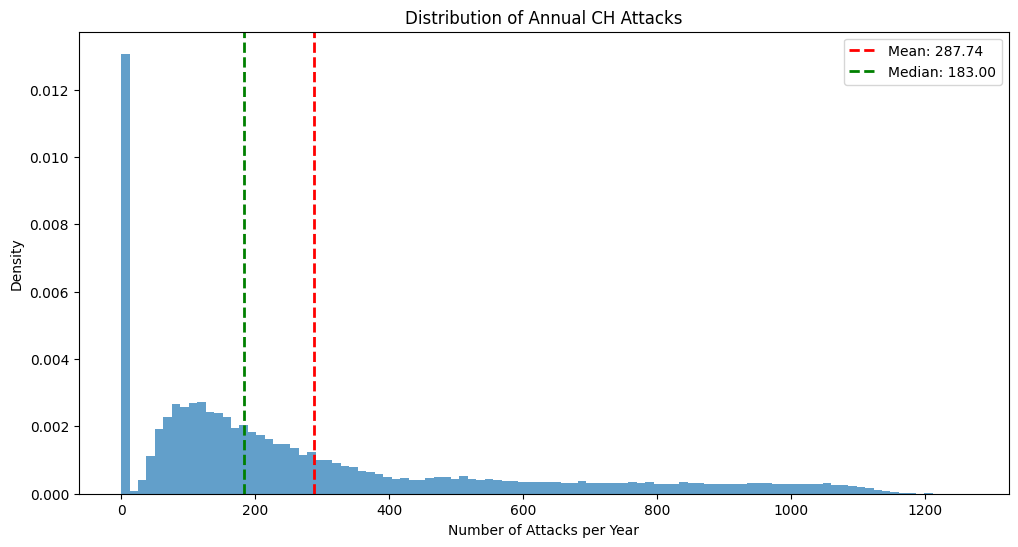

In [130]:
def simulate_annual_attacks(n_simulations=100000):
    annual_attacks = []
    
    for _ in range(n_simulations):
        # Determine if episodic or chronic
        is_episodic = np.random.random() < 0.8
        # is_episodic = True
        
        if is_episodic:
            # Number of bouts (randomly select from pre-generated samples)
            n_bouts = np.random.choice(samples)
            
            # Duration of each bout (in weeks)
            bout_durations = lognorm.rvs(s=optimal_sigma, scale=np.exp(optimal_mu), size=n_bouts)
            
            # Daily attacks for each bout
            daily_attacks = []
            for duration in bout_durations:
                days = int(duration * 7)  # Convert weeks to days
                attacks = np.minimum(lognorm.rvs(s=episodic_sigma, scale=np.exp(episodic_mu), size=days), 8)
                daily_attacks.extend(np.floor(attacks))
            
            total_attacks = sum(daily_attacks)
        
        else:  # Chronic
            # Model active days for chronic sufferers (between 274 and 365 days)
            active_days = np.random.randint(100, 366)
            daily_attacks = np.minimum(lognorm.rvs(s=chronic_sigma, scale=np.exp(chronic_mu), size=active_days), 8)
            total_attacks = sum(daily_attacks)
        
        annual_attacks.append(total_attacks)
    
    return np.array(annual_attacks)

# Run the simulation
annual_attack_distribution = simulate_annual_attacks()

# Calculate statistics
mean_attacks = np.mean(annual_attack_distribution)
median_attacks = np.median(annual_attack_distribution)
percentiles = np.percentile(annual_attack_distribution, [25, 75, 90])

# Print results
print(f"Mean annual attacks: {mean_attacks:.2f}")
print(f"Median annual attacks: {median_attacks:.2f}")
print(f"25th percentile: {percentiles[0]:.2f}")
print(f"75th percentile: {percentiles[1]:.2f}")
print(f"90th percentile: {percentiles[2]:.2f}")

# Plot the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.hist(annual_attack_distribution, bins=100, density=True, alpha=0.7)
plt.title("Distribution of Annual CH Attacks")
plt.xlabel("Number of Attacks per Year")
plt.ylabel("Density")
plt.axvline(mean_attacks, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_attacks:.2f}')
plt.axvline(median_attacks, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_attacks:.2f}')
plt.legend()
plt.show()

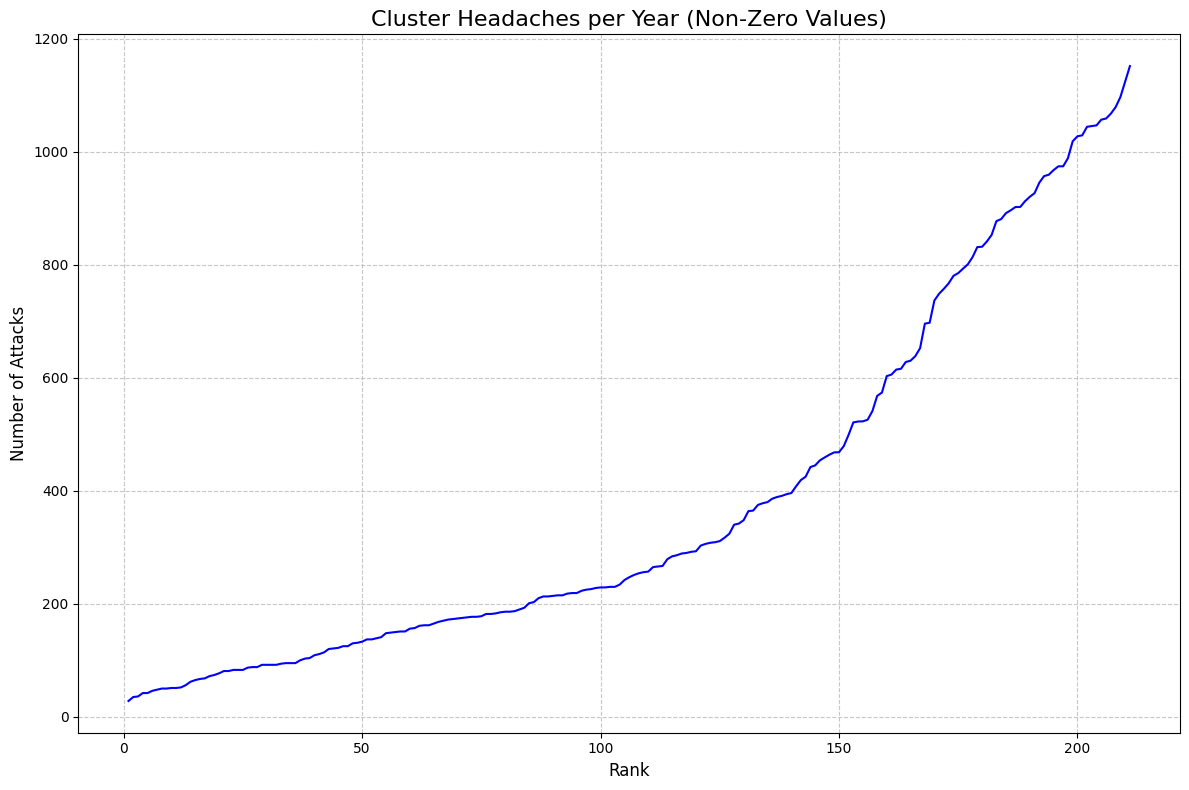

Number of non-zero values: 211
Minimum annual attacks (non-zero): 28
Maximum annual attacks: 1152
Median annual attacks (non-zero): 247


In [131]:
# Sample 250 values from the distribution
sample_size = 250
sampled_attacks = np.random.choice(annual_attack_distribution, size=sample_size, replace=False)

# Filter out zero values and sort in ascending order
non_zero_attacks = sampled_attacks[sampled_attacks > 0]
sorted_attacks = np.sort(non_zero_attacks)

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(sorted_attacks) + 1), sorted_attacks, color='blue')

plt.title('Cluster Headaches per Year (Non-Zero Values)', fontsize=16)
plt.xlabel('Rank', fontsize=12)
plt.ylabel('Number of Attacks', fontsize=12)

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print some statistics about the sampled data
print(f"Number of non-zero values: {len(sorted_attacks)}")
print(f"Minimum annual attacks (non-zero): {sorted_attacks[0]:.0f}")
print(f"Maximum annual attacks: {sorted_attacks[-1]:.0f}")
print(f"Median annual attacks (non-zero): {np.median(sorted_attacks):.0f}")

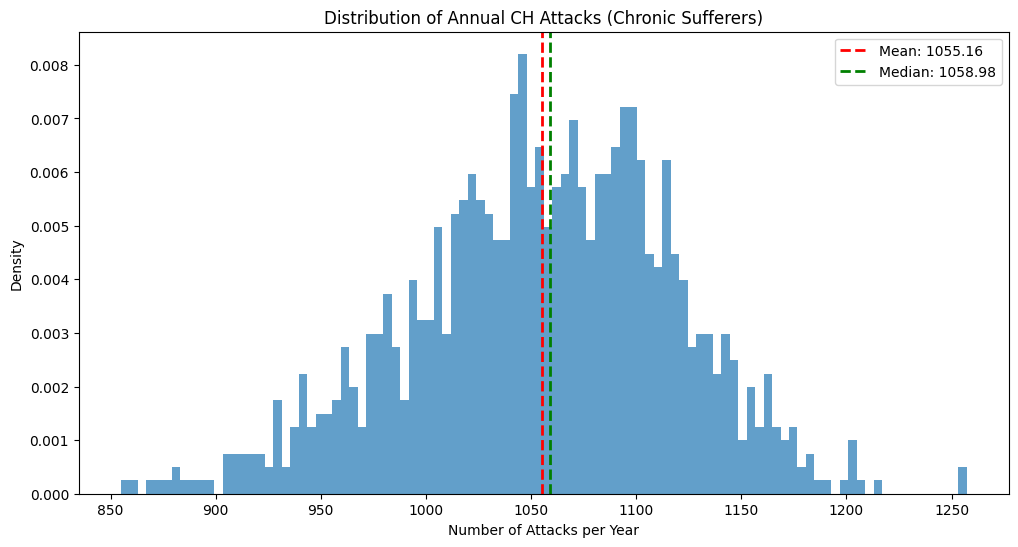

In [73]:
def simulate_chronic_attacks(n_simulations=1000):
    annual_attacks = []
    
    for _ in range(n_simulations):
        # Model active days using a beta distribution
        active_days = int(274 + (365-274) * np.random.beta(5, 2))
        
        # Introduce variability in attack frequency
        daily_mu = np.random.normal(chronic_mu, 0.2, size=active_days)
        daily_sigma = np.random.normal(chronic_sigma, 0.1, size=active_days)
        
        # Generate daily attacks with softer truncation
        daily_attacks = []
        for mu, sigma in zip(daily_mu, daily_sigma):
            attack = lognorm.rvs(s=sigma, scale=np.exp(mu))
            # Softer truncation: any value above 8 has a 90% chance of being set to 8
            if attack > 8 and np.random.random() < 0.9:
                attack = 8
            daily_attacks.append(attack)
        
        total_attacks = sum(daily_attacks)
        annual_attacks.append(total_attacks)
    
    return np.array(annual_attacks)

# Run the simulation and plot
chronic_distribution = simulate_chronic_attacks()
plt.figure(figsize=(12, 6))
plt.hist(chronic_distribution, bins=100, density=True, alpha=0.7)
plt.title("Distribution of Annual CH Attacks (Chronic Sufferers)")
plt.xlabel("Number of Attacks per Year")
plt.ylabel("Density")
plt.axvline(np.mean(chronic_distribution), color='r', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(chronic_distribution):.2f}')
plt.axvline(np.median(chronic_distribution), color='g', linestyle='dashed', linewidth=2, label=f'Median: {np.median(chronic_distribution):.2f}')
plt.legend()
plt.show()